In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import glob
import random
import os
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from  keras.layers import  Dense, Conv2D, MaxPooling2D, Flatten

In [3]:
def prepare_model():
    model = Sequential()
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(100, 100, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
    return model

In [4]:
df = pd.read_csv('data/all_data_info.csv')
df

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
103245,Jackson Pollock,1948.0,abstract,682.0,220.0,96405.0,wikiart,Action painting,Number 13A (Arabesque),train_and_test,True,25525.jpg
103246,Bernardo Strozzi,NaN,religious painting,329.0,456.0,127594.0,wikiart,Baroque,St. Francis of Assisi,train_only,True,47038.jpg
103247,Josef Sima,NaN,landscape,293.0,512.0,102519.0,wikiart,Surrealism,Maisons à la campagne II,train_and_test,False,7680.jpg
103248,Brett Whiteley,1982.0,marina,293.0,512.0,167423.0,wikiart,NaN,Thebe's Revenge,train_and_test,True,9021.jpg


In [5]:
dataset_paths = glob.glob("./data/train/*.jpg")


In [6]:
df['impath'] = df.new_filename.map(lambda x : f'./data/train/{x}' if f'./data/train/{x}' in dataset_paths else '' )


In [7]:
df=df[df['impath']!='']

In [8]:
df_samp = df.sample(1000)

In [9]:
df_samp['image'] = df_samp.new_filename.map(lambda x : np.array(Image.open(f'./data/train/{x}')).reshape(100,100,3))  

In [10]:
img_path= "./data/train"

In [11]:
artists_dirs = list(set([" ".join(filename.split("_")[:-1]) for filename in os.listdir(img_path)]))

In [12]:
artists_dirs

['']

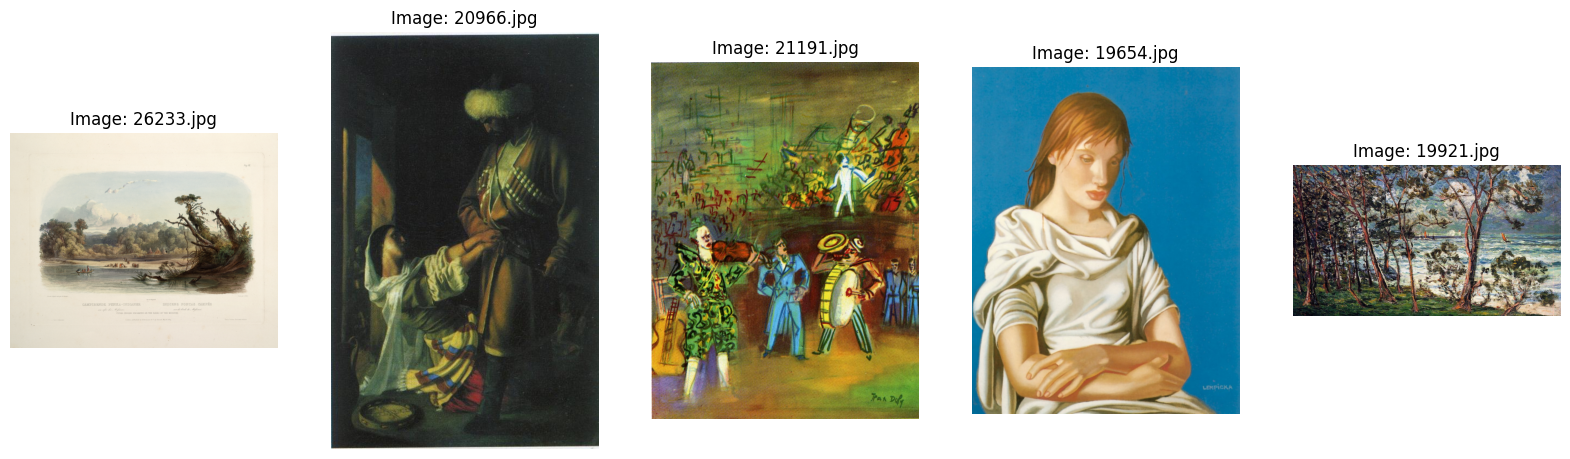

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(20,10))

for i in range(5):
    random_image = random.choice(os.listdir(os.path.join(img_path)))
  
    random_image_file = os.path.join(img_path, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Image: " + random_image)
    axes[i].axis('off')

plt.show()


In [14]:
batch_size = 16
train_input_shape = (224, 224, 3)

In [15]:
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   shear_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )


train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_samp,
    directory=img_path,
    x_col="new_filename",
    y_col="artist",
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42)

# train_generator = train_datagen.flow_from_directory(directory=img_path,
#                                                     class_mode='categorical',
#                                                     target_size=train_input_shape[0:2],
#                                                     batch_size=batch_size,
#                                                     subset="training",
#                                                     shuffle=True,
#                                                     classes=artists_dirs
#                                                    )

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=df_samp,
    directory=img_path,
    x_col="new_filename",
    y_col="artist",
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)




Found 800 validated image filenames belonging to 530 classes.
Found 200 validated image filenames belonging to 530 classes.


In [16]:
test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [17]:
test_generator = test_datagen.flow_from_directory(directory='./data/test',
                                                    batch_size=batch_size,
                                                    
                                                    shuffle=True,
                                                    
                                                   )

Found 0 images belonging to 0 classes.


In [18]:
valid_generator.n//valid_generator.batch_size

12

In [19]:
from torchvision.transforms.functional import to_tensor

In [20]:
X= df_samp.image
y=df_samp['artist']

In [21]:
X

80160    <PIL.JpegImagePlugin.JpegImageFile image mode=...
43352    <PIL.JpegImagePlugin.JpegImageFile image mode=...
46037    <PIL.JpegImagePlugin.JpegImageFile image mode=...
38074    <PIL.JpegImagePlugin.JpegImageFile image mode=...
24761    <PIL.JpegImagePlugin.JpegImageFile image mode=...
                               ...                        
26061    <PIL.JpegImagePlugin.JpegImageFile image mode=...
68111    <PIL.JpegImagePlugin.JpegImageFile image mode=...
92421    <PIL.JpegImagePlugin.JpegImageFile image mode=...
51070    <PIL.JpegImagePlugin.JpegImageFile image mode=...
80572    <PIL.JpegImagePlugin.JpegImageFile image mode=...
Name: image, Length: 1000, dtype: object

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [24]:
X_train

56598    <PIL.JpegImagePlugin.JpegImageFile image mode=...
47862    <PIL.JpegImagePlugin.JpegImageFile image mode=...
63797    <PIL.JpegImagePlugin.JpegImageFile image mode=...
11164    <PIL.JpegImagePlugin.JpegImageFile image mode=...
39000    <PIL.JpegImagePlugin.JpegImageFile image mode=...
                               ...                        
10072    <PIL.JpegImagePlugin.JpegImageFile image mode=...
51291    <PIL.JpegImagePlugin.JpegImageFile image mode=...
4300     <PIL.JpegImagePlugin.JpegImageFile image mode=...
66998    <PIL.JpegImagePlugin.JpegImageFile image mode=...
74712    <PIL.JpegImagePlugin.JpegImageFile image mode=...
Name: image, Length: 750, dtype: object

In [25]:
model = prepare_model()
model.fit(X_train,y_train,epochs=50,callbacks=[es],verbose=1,batch_size=32, validation_split=0.2)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type JpegImageFile).